# 1. Data Manipulation

In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
coupon=pd.read_csv('L2_Week3.csv')
coupon=coupon.rename(columns={'coupon_ind':'coupon_use'})
#Seperate use and non use customers
use= coupon[coupon["coupon_use"] == 1]
not_use= coupon[coupon["coupon_use"] == 0]

#Separating catagorical and numerical columns 
Id_col = ['ID']
target_col = ['coupon_use']
cat_cols = coupon.nunique()[coupon.nunique()<13].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]
num_cols = [x for x in coupon.columns if x not in cat_cols + target_col + Id_col]

#customer id col
Id_col     = ['ID']
#Target columns
target_col = ["coupon_use"]
#categorical columns
cat_cols   = coupon.nunique()[coupon.nunique() < 13].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in coupon.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = coupon.nunique()[coupon.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    coupon[i] = le.fit_transform(coupon[i])
    
#Duplicating columns for multi value columns
coupon = pd.get_dummies(data = coupon,columns = multi_cols )
coupon.drop(['job_unknown'],axis=1,inplace=True) 
#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(coupon[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_coupon_og = coupon.copy()
coupon = coupon.drop(columns = num_cols,axis = 1)
coupon = coupon.drop(columns = 'ID',axis = 1)
coupon = coupon.merge(scaled,left_index=True,right_index=True,how = "left")

1.1 Variable Summary

In [3]:
#Variable Summary
summary = (df_coupon_og[[i for i in df_coupon_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

# 2. Model Building

2.1 Baseline Model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
('\n Classification report : \n', u'              precision    recall  f1-score   support\n\n           0       0.92      0.79      0.85      6733\n           1       0.23      0.49      0.32       863\n\n   micro avg       0.76      0.76      0.76      7596\n   macro avg       0.58      0.64      0.59      7596\nweighted avg       0.85      0.76      0.79      7596\n')
('Accuracy   Score : ', 0.7597419694576093)
('Area under curve : ', 0.6417185791639697, '\n')


/Users/stella/opt/anaconda2/lib/python2.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



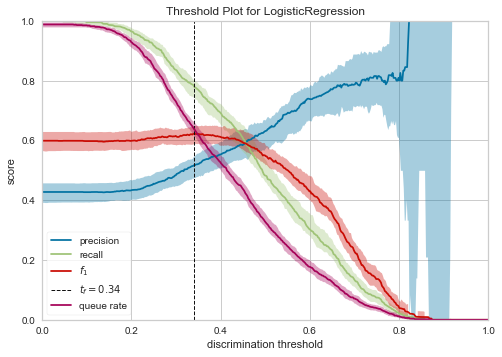

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.utils import resample
#splitting train and test data
train,test = train_test_split(coupon,test_size = 0.3,random_state = 100)

#balancing data(downsampling the majority class)
train_majority = train[train.coupon_use == 0]
train_minority = train[train.coupon_use == 1]
train_majority_downsampled = resample(train_majority,
                                     replace = False,
                                     n_samples = 2832,
                                     random_state = 123)
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

##seperating dependent and independent variables
cols = [i for i in coupon.columns if i not in target_col]
train_X = train_downsampled.drop('coupon_use', axis = 1)
train_Y = train_downsampled.coupon_use
test_X = test[cols]
test_Y = test[target_col]


#Function attributes
#dataframe     - processed dataframe
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic 
                                 #regression,features for tree based models)

#threshold_plot - if True returns threshold plot for model
def coupon_use_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])

    #plot confusion matrix(x = predicted, y = actual)
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not use","Use"],
                        y = ["Not use","Use"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

coupon_use_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

2.2 Sythetic Minority Oversampling TEchinique(SMOTE)
#Randomly pick a point from the minority class.
#Compute the k-nearest neighbors (for some pre-specified k) for this point.
#Add k new points somewhere between the chosen point and each of its neighbors

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
('\n Classification report : \n', u'              precision    recall  f1-score   support\n\n           0       0.94      0.66      0.78      6733\n           1       0.20      0.66      0.31       863\n\n   micro avg       0.66      0.66      0.66      7596\n   macro avg       0.57      0.66      0.54      7596\nweighted avg       0.85      0.66      0.72      7596\n')
('Accuracy   Score : ', 0.6619273301737757)
('Area under curve : ', 0.660289103719268, '\n')


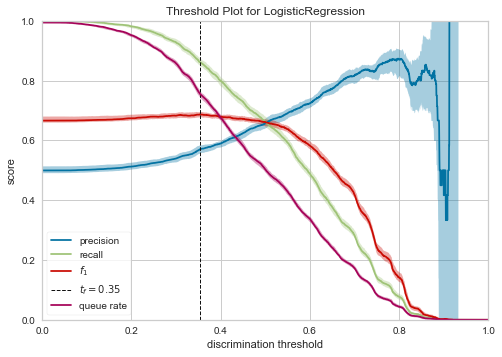

In [5]:
from imblearn.over_sampling import SMOTE
cols = [i for i in coupon.columns if i not in target_col]

smote_X = coupon[cols]
smote_Y = coupon[target_col]

#split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,
                                                                         test_size = .3 ,
                                                                         random_state = 100)
#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)


logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

coupon_use_prediction(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

2.3 Univariate Selection
#Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
#uses the chi squared (chi^2) statistical test for non-negative features to select the best features

In [6]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in coupon.columns if i not in target_col ]

#dataframe with non negative values
df_x = df_coupon_og[cols]
df_y = df_coupon_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 3)
fit    = select.fit(df_x,df_y)

#Summerize scores
print ("scores")
print (fit.scores_)
print ("P - Values")
print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

scores
[1.50596266e+01 2.32917896e+02 9.04547821e+01 1.98439640e-03
 1.11910522e+02 1.24043050e+01 5.57747790e+00 2.48547758e+01
 1.69121569e+02 2.83925819e-02 1.63639997e+01 1.18195774e+02
 5.14694824e-01 1.41556841e+01 1.66050370e-01 3.01866111e+01
 6.01969001e+01 6.25927608e+01 5.07568301e+02 6.88129448e+02]
P - Values
[1.04167615e-004 1.37725752e-052 1.89252963e-021 9.64468736e-001
 3.73805604e-026 4.28345191e-004 1.81929043e-002 6.18157087e-007
 1.15087292e-038 8.66189169e-001 5.22686378e-005 1.57091662e-027
 4.73113535e-001 1.68287889e-004 6.83646092e-001 3.92409125e-008
 8.58272636e-015 2.54186068e-015 2.14429857e-112 1.14042096e-151]


2.4 Decision Tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')
('\n Classification report : \n', u'              precision    recall  f1-score   support\n\n           0       0.92      0.86      0.89      6733\n           1       0.28      0.41      0.33       863\n\n   micro avg       0.81      0.81      0.81      7596\n   macro avg       0.60      0.64      0.61      7596\nweighted avg       0.85      0.81      0.83      7596\n')
('Accuracy Score   : ', 0.8105581885202738)
('Area under curve : ', 0.6375510082558038)


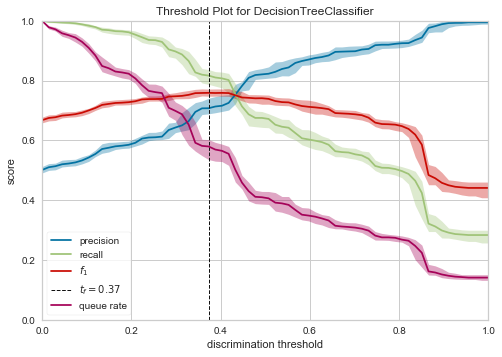

In [7]:
from sklearn.tree import DecisionTreeClassifier

def coupon_use_prediction_alg(algorithm,training_x,testing_x,
                                 training_y,testing_y,threshold_plot = True) :
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy Score   : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc)
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
     
    #plot roc curve
    trace1 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2),
                       )
    trace2 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot confusion matrix
    trace3 = go.Heatmap(z = conf_matrix ,x = ["Not use","Use"],
                        y = ["Not use","Use"],
                        showscale  = False,colorscale = "Blues",name = "matrix",
                        xaxis = "x2",yaxis = "y2"
                       )
    
    layout = go.Layout(dict(title="Model performance" ,
                            autosize = False,height = 500,width = 800,
                            showlegend = False,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(title = "false positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         domain=[0, 0.6],
                                         ticklen=5,gridwidth=2),
                            yaxis = dict(title = "true positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         zerolinewidth=1,
                                         ticklen=5,gridwidth=2),
                            margin = dict(b=200),
                            xaxis2=dict(domain=[0.7, 1],tickangle = 90,
                                        gridcolor = 'rgb(255, 255, 255)'),
                            yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                           )
                  )
    data = [trace1,trace2,trace3]
    fig = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
    
decision_tree = DecisionTreeClassifier(max_depth = 9,
                                       random_state = 123,
                                       splitter  = "best",
                                       criterion = "gini",
                                      )
coupon_use_prediction_alg(decision_tree,os_smote_X,test_X,os_smote_Y,test_Y,threshold_plot = True)

2.5 KNN Classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
('\n Classification report : \n', u'              precision    recall  f1-score   support\n\n           0       0.91      0.80      0.85      6733\n           1       0.21      0.41      0.27       863\n\n   micro avg       0.75      0.75      0.75      7596\n   macro avg       0.56      0.60      0.56      7596\nweighted avg       0.83      0.75      0.79      7596\n')
('Accuracy Score   : ', 0.7540810953133228)
('Area under curve : ', 0.604177655961652)


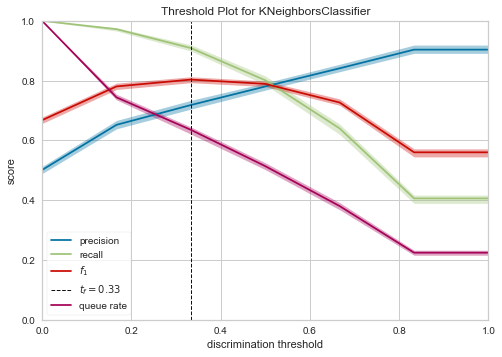

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
coupon_use_prediction_alg(knn,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

2.6 Vizualising a decision tree from random forest classifier

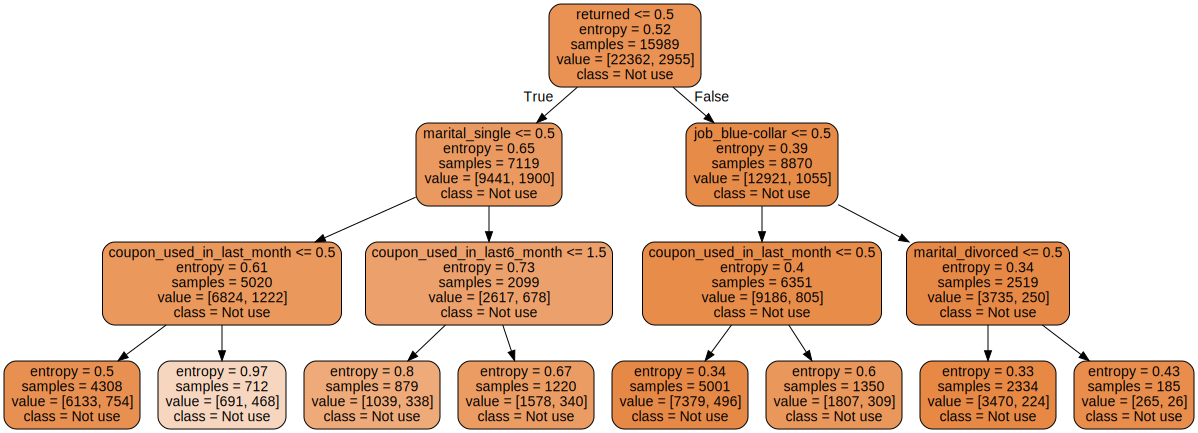

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
('\n Classification report : \n', u'              precision    recall  f1-score   support\n\n           0       0.89      1.00      0.94      6733\n           1       0.00      0.00      0.00       863\n\n   micro avg       0.89      0.89      0.89      7596\n   macro avg       0.44      0.50      0.47      7596\nweighted avg       0.79      0.89      0.83      7596\n')
('Accuracy   Score : ', 0.8863875724065298)
('Area under curve : ', 0.5, '\n')


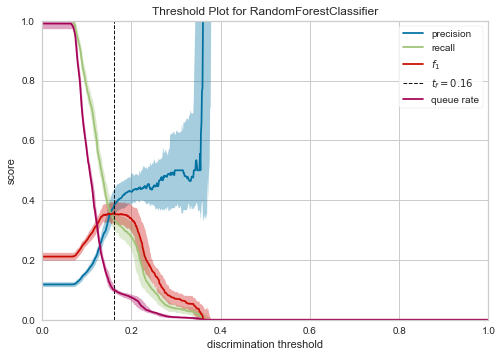

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

#function attributes
#columns  - column used
#nf_estimators   - The number of trees in the forest.
#estimated_tree  - tree number to be displayed
#maximum_depth   - depth of the tree
#criterion_type  - split criterion type ["gini" or "entropy"]
#Model performance - prints performance of model

def plot_tree_randomforest(columns,nf_estimators,
                           estimated_tree,maximum_depth,
                           criterion_type,model_performance = None) :
    
    dataframe = df_coupon_og[columns + target_col].copy()
    
    #train and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                  )
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
                                        rounded=True,proportion = False,
                            feature_names = columns, 
                            precision  = 2,
                            class_names=["Not use","Use"],
                            filled = True))
    display(graph)
    
    #model performance
    if model_performance == True :
        coupon_use_prediction(rfc,
                                 rf_x,test_X[columns],
                                 rf_y,test_Y,
                                 columns,"features",threshold_plot = True)
        

cols1 = [ i for i in train_X.columns if i not in target_col] 
plot_tree_randomforest(cols1,100,99,3,"entropy",True)

2.7 A random forest classifer
#A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement .
#Below are the trees produced by random forest model with 10 estimated trees with maximum depth of three for each tree. Each tree produced is slightly different from other.

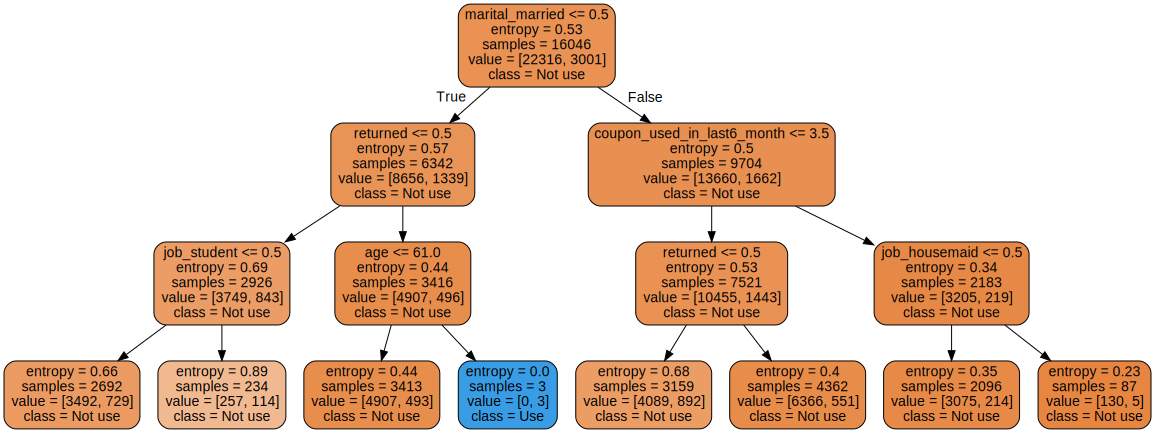

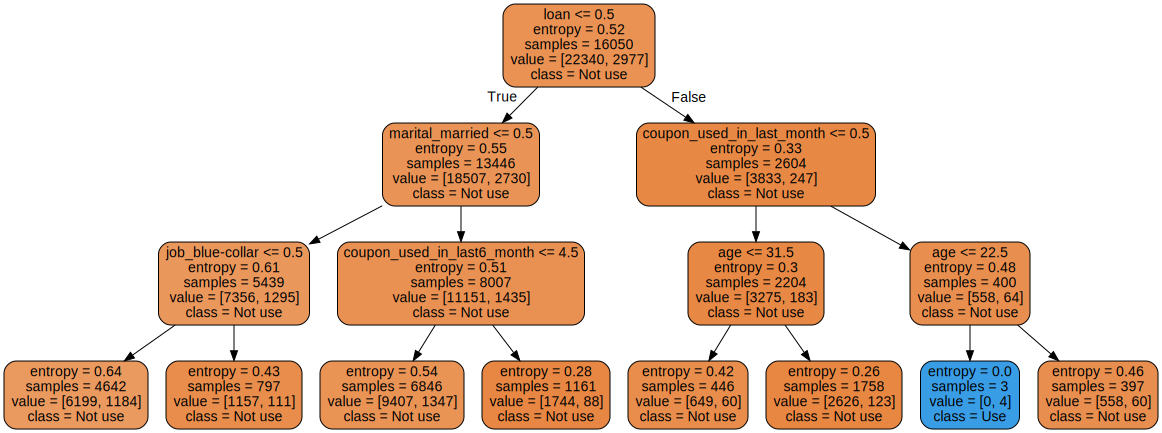

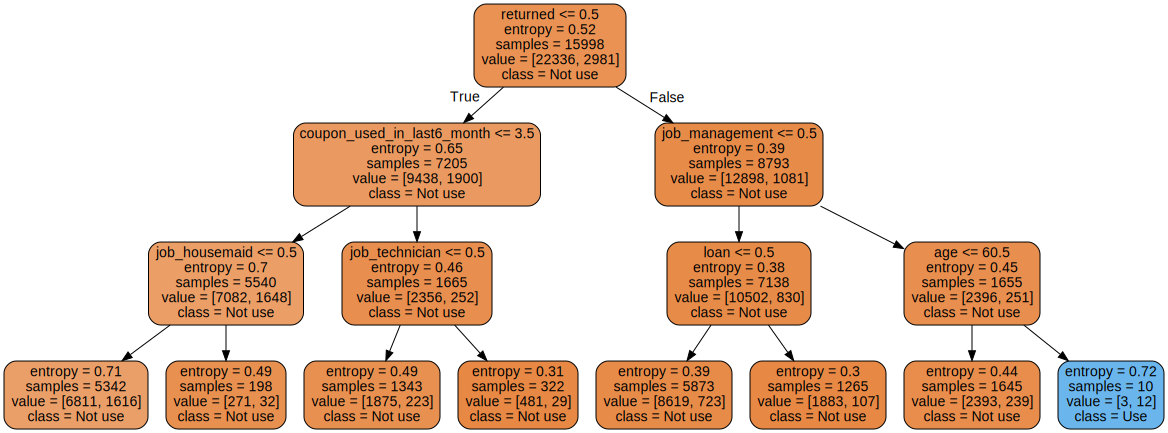

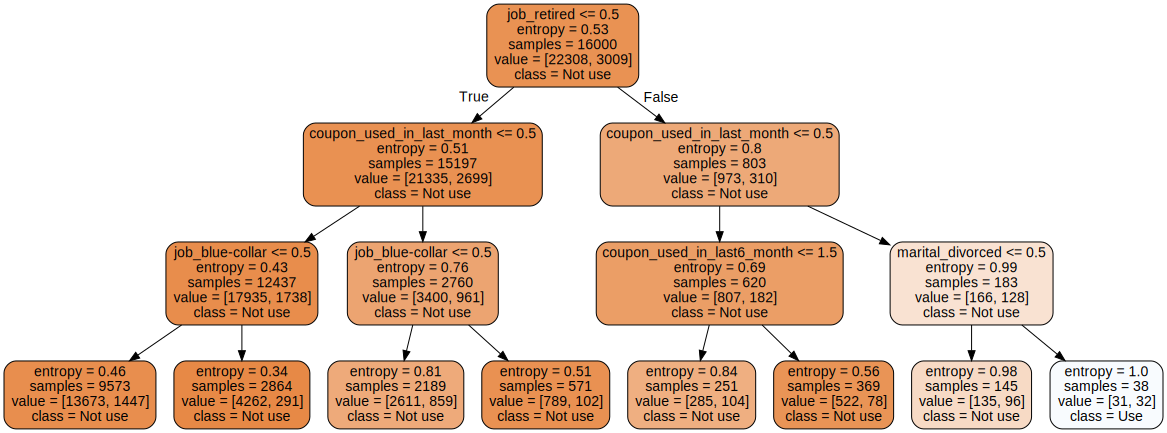

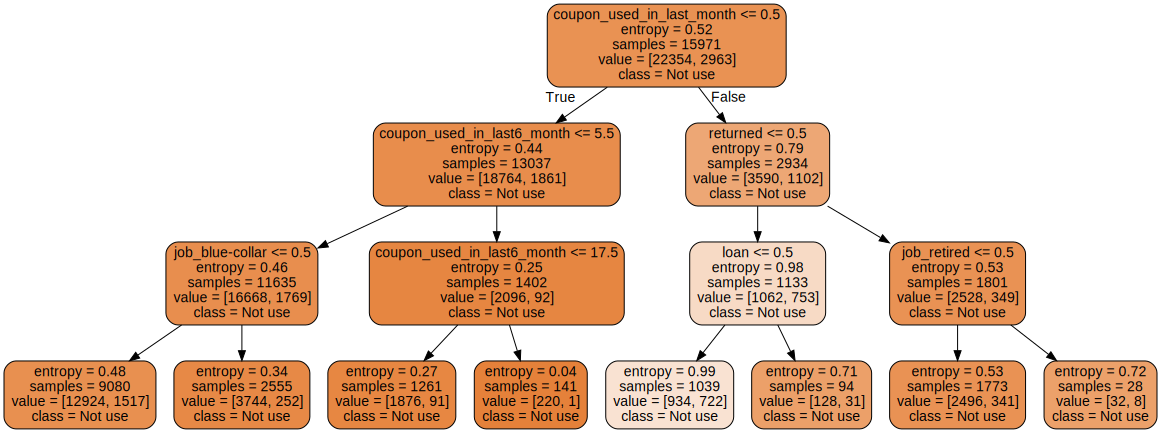

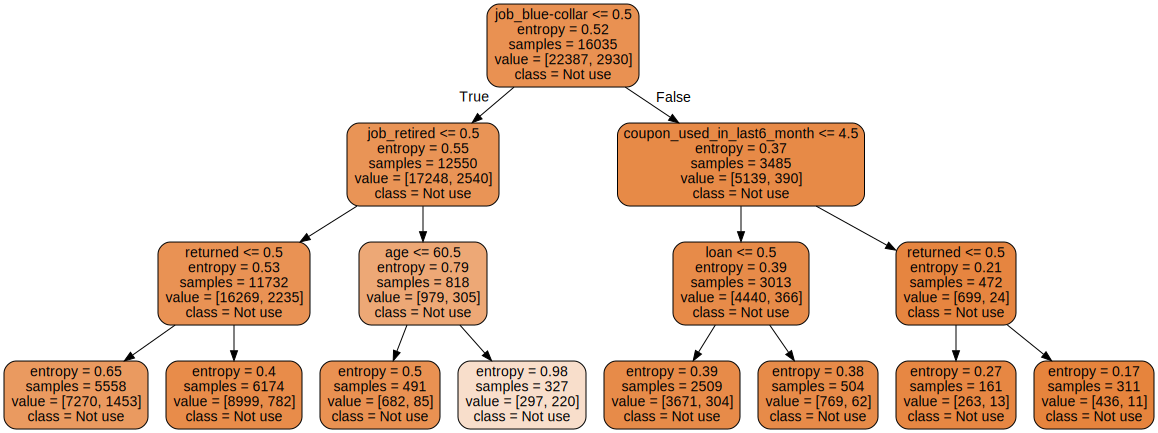

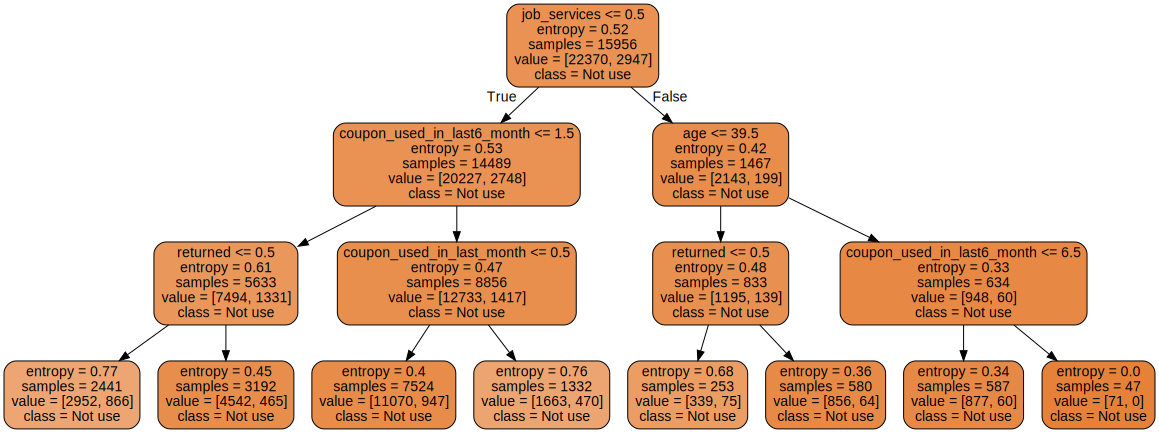

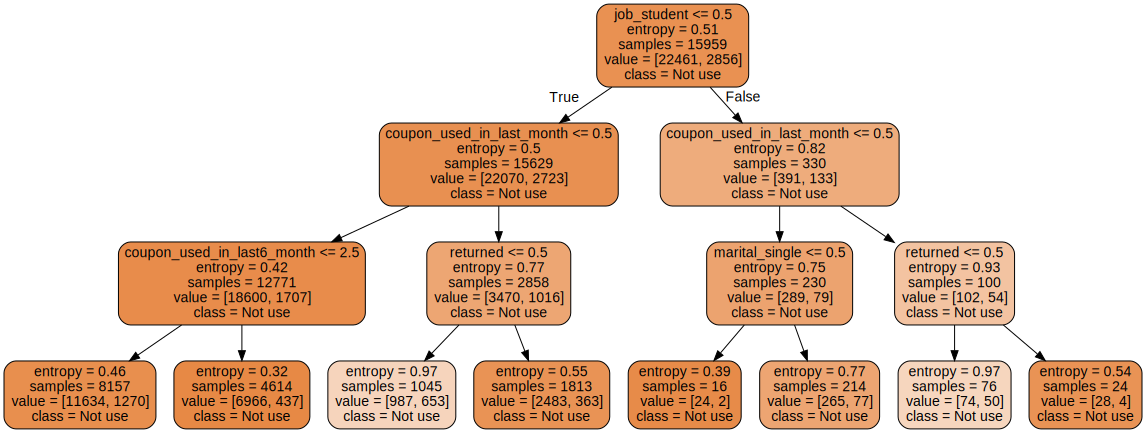

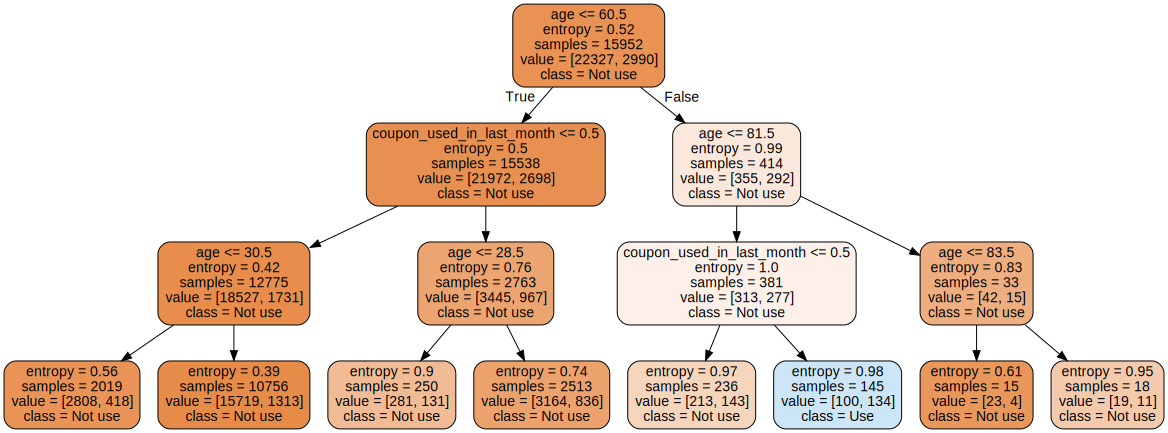

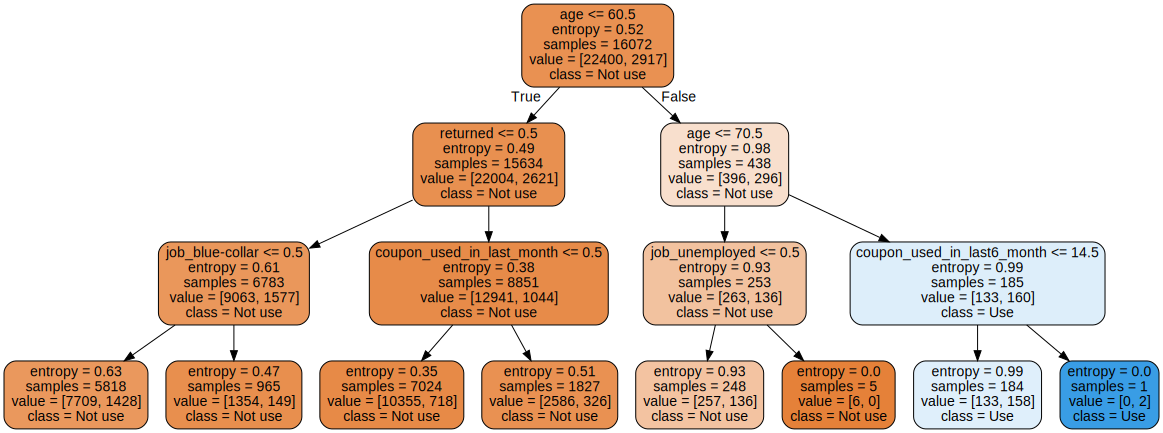

In [10]:
#making 10 trees with random forest.
n = np.arange(0,10).tolist()
cols1 = [ i for i in train_X.columns if i not in target_col] 
for i in n :
    plot_tree_randomforest(cols1,10,i,3,"entropy",model_performance=False)

2.8 Gaussian Naive Bayes

GaussianNB(priors=None, var_smoothing=1e-09)
('\n Classification report : \n', u'              precision    recall  f1-score   support\n\n           0       0.93      0.53      0.68      6733\n           1       0.16      0.70      0.26       863\n\n   micro avg       0.55      0.55      0.55      7596\n   macro avg       0.55      0.62      0.47      7596\nweighted avg       0.84      0.55      0.63      7596\n')
('Accuracy Score   : ', 0.5498946814112691)
('Area under curve : ', 0.6152769801425986)


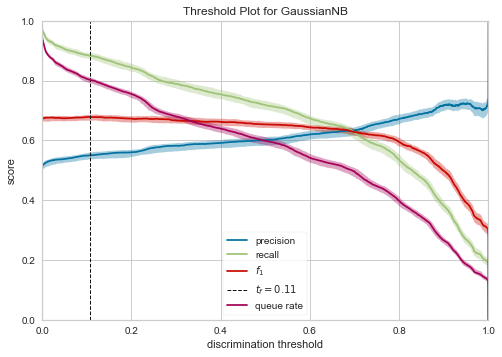

In [11]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)

coupon_use_prediction_alg(gnb,os_smote_X,test_X,os_smote_Y,test_Y)

2.9 Support Vector Classifier

In [12]:
from sklearn.svm import SVC
#using linear hyper plane
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)
cols = [i for i in coupon.columns if i not in target_col]
coupon_use_prediction(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = False)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
('\n Classification report : \n', u'              precision    recall  f1-score   support\n\n           0       0.93      0.65      0.76      6733\n           1       0.18      0.61      0.28       863\n\n   micro avg       0.64      0.64      0.64      7596\n   macro avg       0.56      0.63      0.52      7596\nweighted avg       0.84      0.64      0.71      7596\n')
('Accuracy   Score : ', 0.6445497630331753)
('Area under curve : ', 0.628766771779542, '\n')


In [13]:
#tuning parameters
#Support vector classifier
#using non-linear hyper plane("rbf")

svc_rbf  = SVC(C=1.0, kernel='rbf', 
               degree= 3, gamma=1.0, 
               coef0=0.0, shrinking=True,
               probability=True,tol=0.001,
               cache_size=200, class_weight=None,
               verbose=False,max_iter= -1,
               random_state=None)

coupon_use_prediction_alg(svc_rbf,os_smote_X,test_X,os_smote_Y,test_Y,threshold_plot = False)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
('\n Classification report : \n', u'              precision    recall  f1-score   support\n\n           0       0.92      0.75      0.83      6733\n           1       0.21      0.52      0.30       863\n\n   micro avg       0.73      0.73      0.73      7596\n   macro avg       0.57      0.64      0.57      7596\nweighted avg       0.84      0.73      0.77      7596\n')
('Accuracy Score   : ', 0.7265666140073723)
('Area under curve : ', 0.6376530634898863)


# 3. Model Performance

3.1 model performace metric

In [14]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Logistic Regression(Baseline_model)")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Logistic Regression(SMOTE)")
model3 = model_report(decision_tree,train_X,test_X,train_Y,test_Y,
                      "Decision Tree")
model4 = model_report(knn,os_smote_X,test_X,os_smote_Y,test_Y,
                      "KNN Classifier")
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model5 = model_report(rfc,train_X,test_X,train_Y,test_Y,
                      "Random Forest Classifier")
model6 = model_report(gnb,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Naive Bayes")
model7 = model_report(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier Linear")
model8 = model_report(svc_rbf,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier RBF")


#concat all models
model_performances = pd.concat([model1,model2,model3,
                                model4,model5,model6,
                                model7,model8],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

3.2 Compare model metrics

In [15]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

3.3 Confusion matrics for models

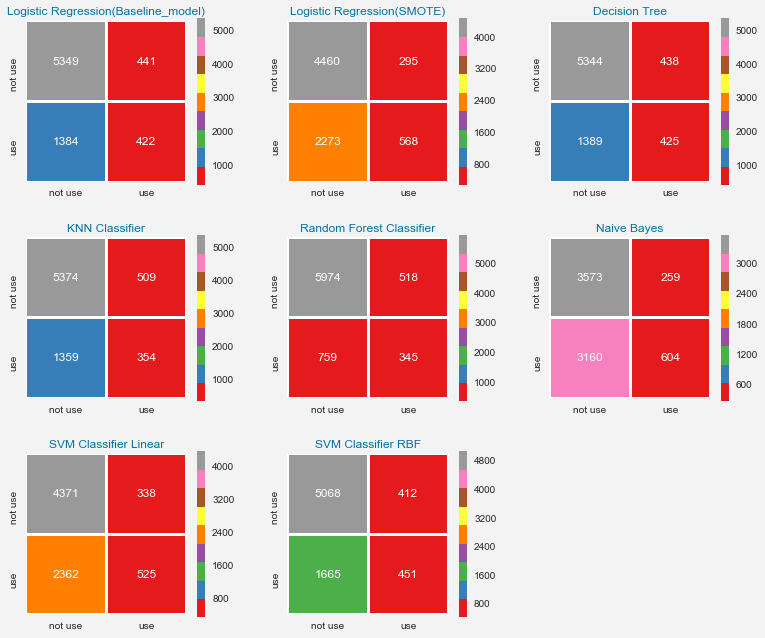

In [16]:
lst    = [logit,logit_smote,decision_tree,knn,rfc,
          gnb,svc_lin,svc_rbf]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(SMOTE)',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.izip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    predictions = i.predict(test_X)
    conf_matrix = confusion_matrix(predictions,test_Y)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["not use","use"],
                yticklabels=["not use","use"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)

3.4 ROC - Curves for models

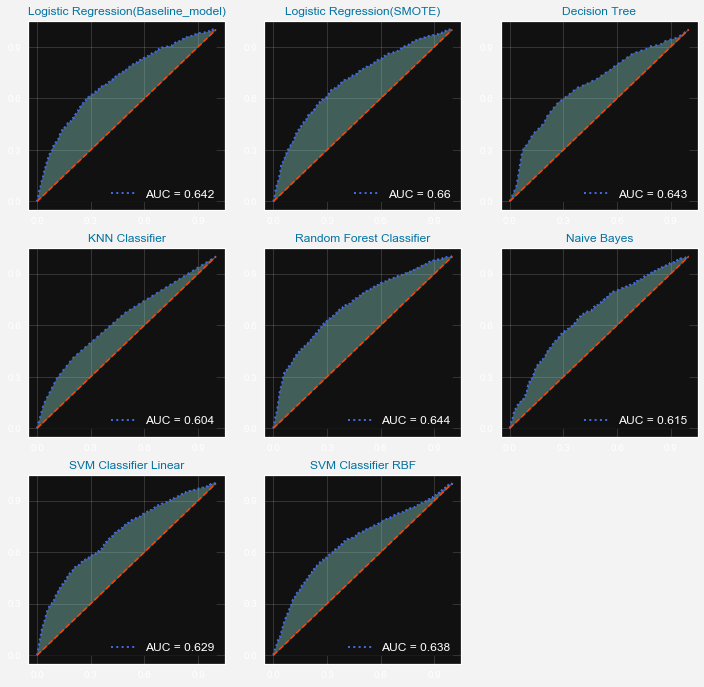

In [17]:
lst    = [logit,logit_smote,decision_tree,knn,rfc,
          gnb,svc_lin,svc_rbf]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(SMOTE)',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF']

plt.style.use("dark_background")
fig = plt.figure(figsize=(12,16))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.izip_longest(lst,range(length),mods) :
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    fpr,tpr,thresholds = roc_curve(test_Y,probabilities[:,1])
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(roc_auc_score(test_Y,predictions),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.fill_between(fpr,tpr,alpha = .4)
    plt.fill_between([0,1],[0,1],color = "k")
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xticks(np.arange(0,1,.3))
    plt.yticks(np.arange(0,1,.3))

3.5 Precision recall curves

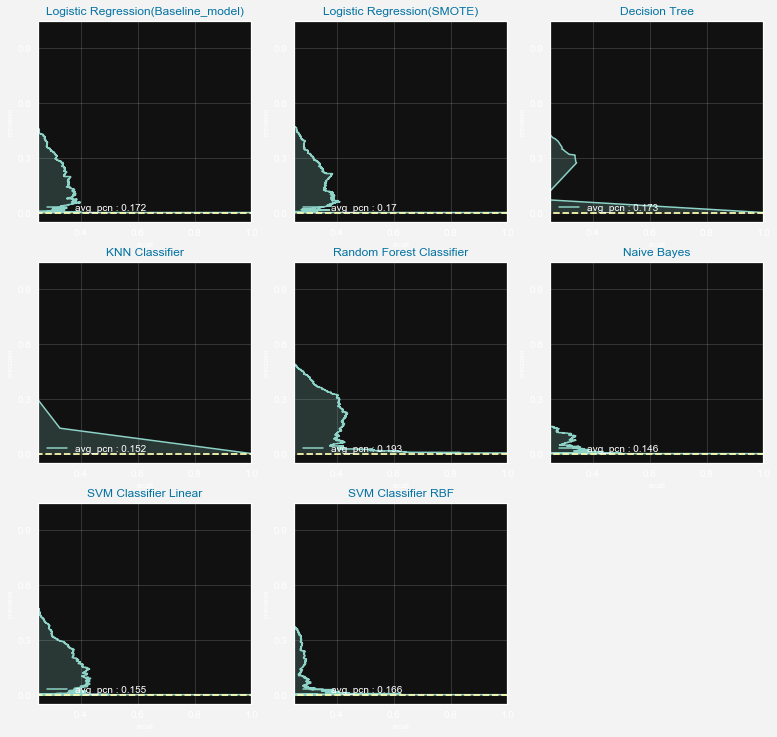

In [18]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


lst    = [logit,logit_smote,decision_tree,knn,rfc,
          gnb,svc_lin,svc_rbf]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(SMOTE)',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF']

fig = plt.figure(figsize=(13,17))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.izip_longest(lst,range(length),mods) :
    
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    recall,precision,thresholds = precision_recall_curve(test_Y,probabilities[:,1])
    plt.plot(recall,precision,linewidth = 1.5,
             label = ("avg_pcn : " + 
                      str(np.around(average_precision_score(test_Y,predictions),3))))
    plt.plot([0,1],[0,0],linestyle = "dashed")
    plt.fill_between(recall,precision,alpha = .2)
    plt.legend(loc = "lower left",
               prop = {"size" : 10})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xlabel("recall",fontsize =7)
    plt.ylabel("precision",fontsize =7)
    plt.xlim([0.25,1])
    plt.yticks(np.arange(0,1,.3))